In [1]:
import pandas as pd
import numpy as np
import math 
import pandas_profiling as pp

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import prince

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from xgboost import DMatrix
from xgboost import train
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [3]:
def frequencies_plot(dataset, hue, cols=2, width=20, height=15, hspace=0.4, wspace=0.5):
    '''
    plots bar charts of categorical variables
    '''
    dataset = dataset.select_dtypes(include=[np.object])
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        plot = sns.countplot(y=column, hue=hue, data=dataset)
        ax.set(ylabel='')

In [4]:
def method_output(model):
    '''
    prints output - accuracy, precision, recall, f1 score and confusion matrix for given model 
    returns predictions for test set
    '''
    predict = model.predict(X_test)
    clf_conf_matrix = confusion_matrix(y_test, predict)
    clf_test_score = accuracy_score(y_test, predict)
    clf_train_score = accuracy_score(y_train, model.predict(X_train))
    clf_report_0 = pd.DataFrame.from_dict(classification_report(y_test, predict, output_dict=True)['0'], orient='index')[:3]
    clf_report_1 = pd.DataFrame.from_dict(classification_report(y_test, predict, output_dict=True)['1'], orient='index')[:3].rename(columns={0: 1})
    clf_report = pd.concat([clf_report_0, clf_report_1], axis=1).round(3)
    print('Test set confusion matrix:\n', clf_conf_matrix, '\n')
    print('Classification report:\n', clf_report, '\n')
    print('Test set accurancy score:\n', round(clf_test_score,3), '\n')
    print('Train set accurancy score:\n', round(clf_train_score,3), '\n')
    
    return predict

In [5]:
def plot_feature_importance(importance, columns, model_type=''):
    '''
    plots feature importances for given ml model
    '''

    importance_df = pd.DataFrame({'feature': columns,'importance': importance}).sort_values(by=['importance'], ascending=False)

    plt.figure(figsize=(10,8))
    sns.barplot(x=importance_df['importance'], y=importance_df['feature'])
    plt.title(model_type.upper() + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [6]:
def roc_curve_plot(predictions, models):
    '''
    plots roc curves for given models 
    '''
    roc_values = {}
    for i in list(predictions.keys()):
        roc_values[f"{i}_false_positive_rate"] = roc_curve(y_test, predictions[i])[0]
        roc_values[f"{i}_true_positive_rate"] = roc_curve(y_test, predictions[i])[1]
    
    plt.figure(figsize=(16,8))
    plt.title('Reciver Operating Characterstic Curve')
    for i in range(0, len(roc_values.keys()), 2):
        plt.plot(roc_values[list(roc_values.keys())[i]], roc_values[list(roc_values.keys())[i+1]], label=models[int(i/2)])  
    plt.plot([0,1],ls='--')
    plt.plot([0,0],[1,0],c='.5')
    plt.plot([1,1],c='.5')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.legend()
    plt.show()

In [7]:
def scores(predictions):
    '''
    returns accuracy, precision and AUC for given models
    '''
    scores = {}
    for i in list(predictions.keys()):
        scores[f"{i}"] = [round(accuracy_score(y_test, predictions[i]),3), 
                          round(float(pd.DataFrame.from_dict(classification_report(y_test, predictions[i], output_dict=True)['1'], orient='index').iloc[0]),3), 
                          round(roc_auc_score(y_test, predictions[i]),3)]
    
    return pd.DataFrame(scores, index=['precision', 'accurancy_score', 'auc_score']).sort_values(by=["accurancy_score", "precision"],axis=1, ascending=False)

In [8]:
adult = pd.read_csv('adult.csv', header=None, skipinitialspace=True)
adult_test = pd.read_csv('adult_test.csv', header=None, skipinitialspace=True, skiprows=1, delimiter=',')
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 
             'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

adult.columns = col_names
adult_test.columns = col_names
adult_test['income'].replace(['<=50K.', '>50K.'], ['<=50K', '>50K'], inplace = True)
adult.head()

age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

In [9]:
pp.ProfileReport(adult)

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
pp.ProfileReport(adult_test)

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
adult.drop_duplicates(inplace=True)
adult_test.drop_duplicates(inplace=True)

In [12]:
adult.isin(['?']).sum(axis=0)

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     582
income               0
dtype: int64

In [13]:
adult_test.isin(['?']).sum(axis=0)

age                 0
workclass         963
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation        966
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    274
income              0
dtype: int64

In [14]:
for c in col_names:
    num_non = adult[c].isin(["?"]).sum()
    if num_non > 0:
        print (c)
        print (num_non)
        print ("{0:.2f}%".format(float(num_non) / adult.shape[0] * 100))
        print ("\n")

workclass
1836
5.64%


occupation
1843
5.66%


native_country
582
1.79%




In [15]:
for c in col_names:
    num_non = adult_test[c].isin(["?"]).sum()
    if num_non > 0:
        print (c)
        print (num_non)
        print ("{0:.2f}%".format(float(num_non) / adult_test.shape[0] * 100))
        print ("\n")

workclass
963
5.92%


occupation
966
5.94%


native_country
274
1.68%




In [16]:
raw_shape = adult.shape
raw_shape_test = adult_test.shape

In [17]:
adult = adult[adult["workclass"] != "?"]
adult = adult[adult["occupation"] != "?"]
adult = adult[adult["native_country"] != "?"]

In [18]:
adult_test = adult_test[adult_test["workclass"] != "?"]
adult_test = adult_test[adult_test["occupation"] != "?"]
adult_test = adult_test[adult_test["native_country"] != "?"]

In [19]:
adult = adult[adult["workclass"] != "Without-pay"]
adult_test = adult_test[adult_test["workclass"] != "Without-pay"]

In [20]:
reduced_shape = adult.shape
reduced_shape_test = adult_test.shape

In [21]:
(1-reduced_shape[0]/raw_shape[0])*100

7.413098933521834

In [22]:
(1-reduced_shape_test[0]/raw_shape_test[0])*100

7.544851314819367

In [23]:
adult = adult.loc[:, adult.columns != 'native_country'] 
adult_test = adult_test.loc[:, adult_test.columns != 'native_country'] 

adult = adult.loc[:, adult.columns != 'education_num'] 
adult_test = adult_test.loc[:, adult_test.columns != 'education_num'] 

In [24]:
for i in adult['occupation'].unique():
    rep = adult['occupation'].isin([i]).sum()
    if (float(rep) / adult.shape[0] * 100) < 0.1:
        print (i)

Armed-Forces


In [25]:
for i in adult_test['occupation'].unique():
    rep = adult_test['occupation'].isin([i]).sum()
    if (float(rep) / adult_test.shape[0] * 100) < 0.1:
        print (i)

Armed-Forces


In [26]:
adult['occupation'].replace(['Armed-Forces'], ['Protective-serv'], inplace = True)
adult_test['occupation'].replace(['Armed-Forces'], ['Protective-serv'], inplace = True)

In [27]:
adult['workclass'].replace(['State-gov', 'Federal-gov', 'Local-gov'], ['Gov', 'Gov', 'Gov'], inplace = True)
adult_test['workclass'].replace(['State-gov', 'Federal-gov', 'Local-gov'], ['Gov', 'Gov', 'Gov'], inplace = True)

In [28]:
adult['marital_status'].replace(['Never-married', 'Divorced', 'Separated', 'Widowed', 'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'], 
                                ['Not-married', 'Not-married', 'Not-married', 'Not-married', 'Married', 'Married', 'Married'], inplace = True)
adult_test['marital_status'].replace(['Never-married', 'Divorced', 'Separated', 'Widowed', 'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'], 
                                     ['Not-married', 'Not-married', 'Not-married', 'Not-married', 'Married', 'Married', 'Married'], inplace = True)

In [29]:
adult['education'].replace(['11th', '9th', '7th-8th', '10th', '5th-6th', '1st-4th', '12th', 'Preschool', 'HS-grad', 'Some-college', 'Assoc-acdm', 'Assoc-voc'], 
                           ['no_edu', 'no_edu', 'no_edu', 'no_edu', 'no_edu', 'no_edu', 'no_edu', 'no_edu', 'High_school', 'College', 'College', 'College'], inplace = True)
adult_test['education'].replace(['11th', '9th', '7th-8th', '10th', '5th-6th', '1st-4th', '12th', 'Preschool', 'HS-grad', 'Some-college', 'Assoc-acdm', 'Assoc-voc'], 
                                ['no_edu', 'no_edu', 'no_edu', 'no_edu', 'no_edu', 'no_edu', 'no_edu', 'no_edu', 'High_school', 'College', 'College', 'College'], inplace = True)

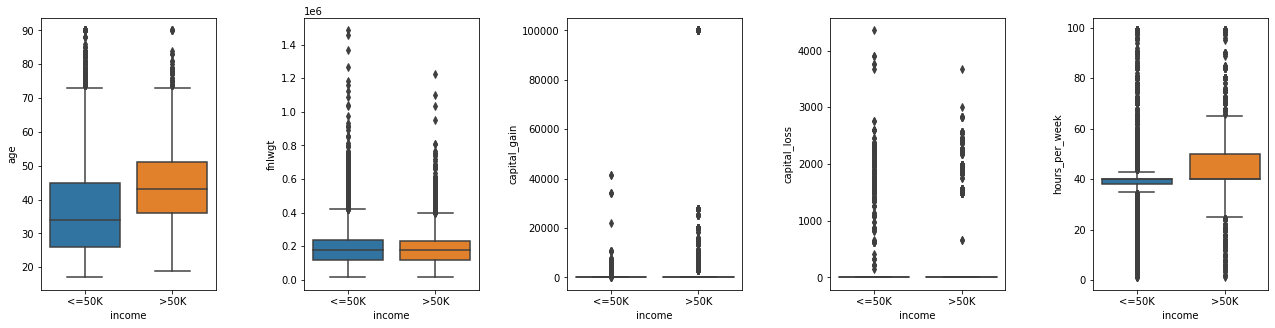

In [30]:
fig, axs = plt.subplots(1, 5, figsize=(22,5))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5)
for c, i in zip(adult.select_dtypes(include=[np.int64]).columns, range(len(adult.select_dtypes(include=[np.int64]).columns))):
    sns.boxplot(x='income', y=c, data=adult, ax=axs[i]);

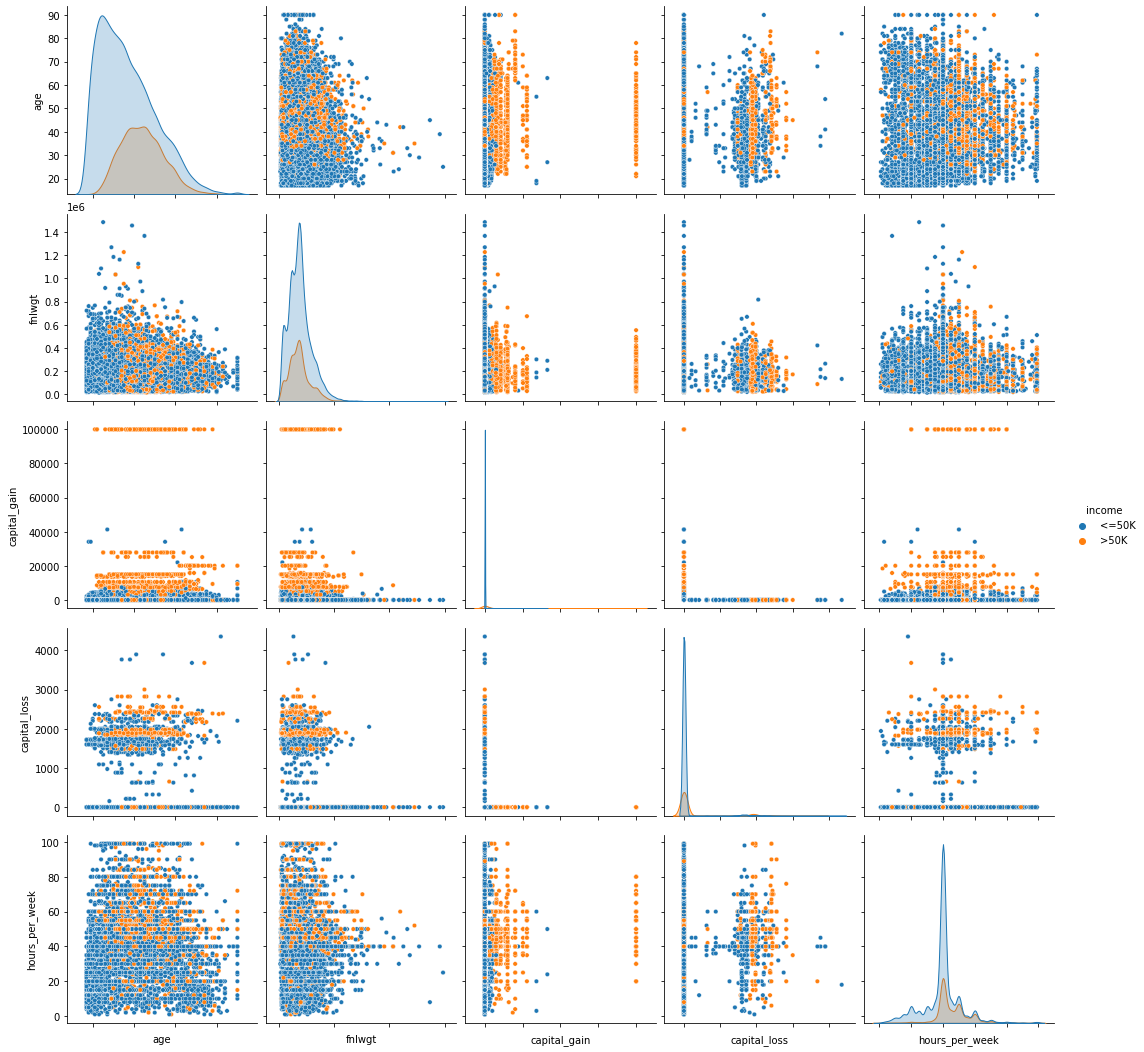

In [31]:
pp = sns.pairplot(adult, hue = 'income', height=3, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=20) )
pp.set(xticklabels=[]);

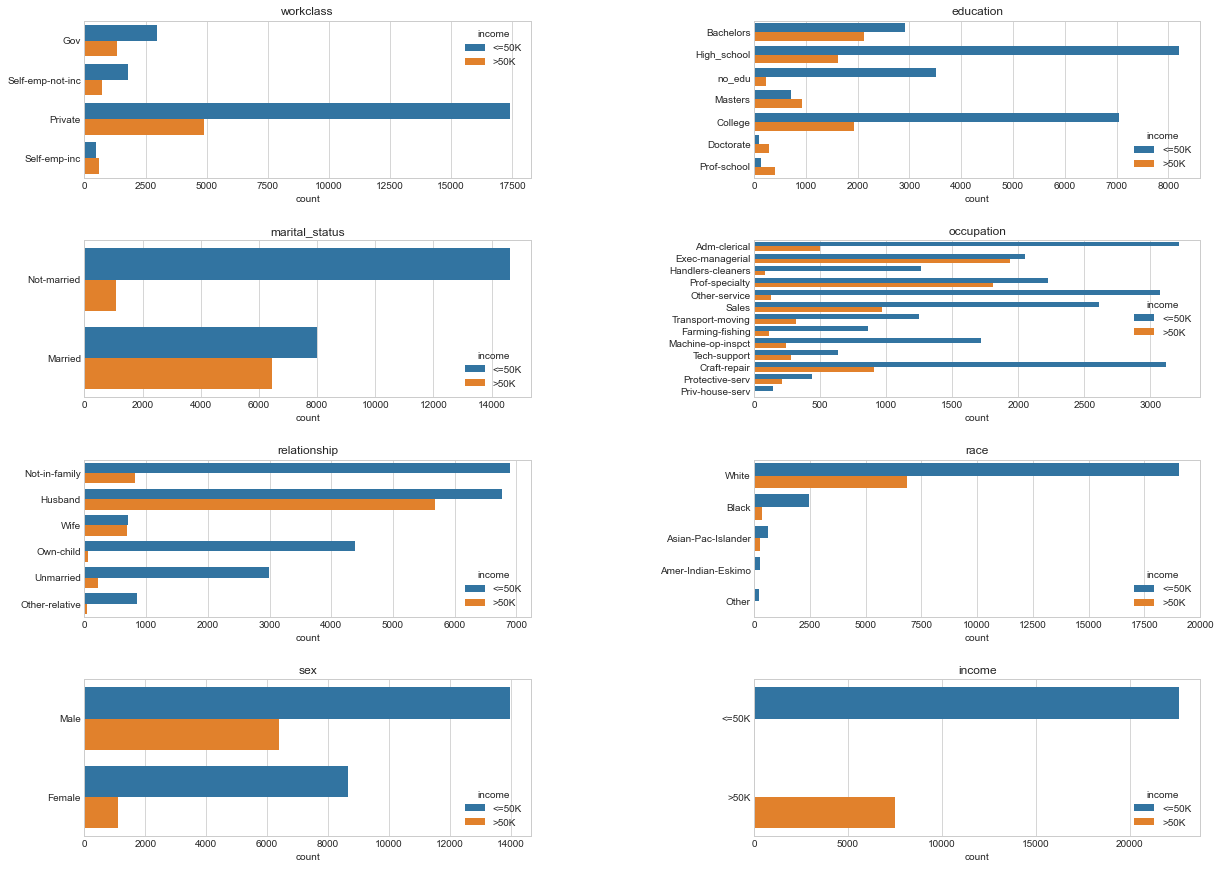

In [32]:
frequencies_plot(adult, hue='income')

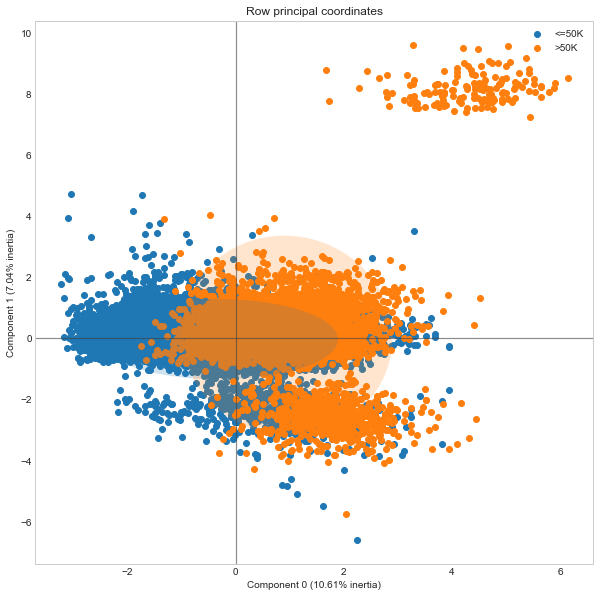

In [34]:
X = adult.drop('income', axis=1)
y = adult['income']

famd = prince.FAMD(n_components=2, copy=True)
famd = famd.fit(X)

ax = famd.plot_row_coordinates(X, figsize=(10,10), color_labels=['{}'.format(i) for i in y])

In [35]:
adult_encoded = pd.concat([adult, adult_test])
encoders = []
for c in adult_encoded.columns:
    if adult_encoded.dtypes[c] == np.object:
        cat_col = adult_encoded[c].astype('category')
        adult_encoded[c] = cat_col.cat.codes
        d = dict(enumerate(cat_col.cat.categories))
        encoders.append(d)

In [36]:
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

adult_scaled = adult_encoded.copy()
col_names = ['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week']
features = adult_scaled[col_names]
scaler = standard_scaler.fit_transform(features)
adult_scaled[col_names] = scaler

adult_scaled.head()

age  workclass    fnlwgt  education  marital_status  occupation  \
0  0.034238          0 -1.062343          0               1           0   
1  0.866901          3 -1.007489          0               0           2   
2 -0.041459          1  0.245140          3               1           4   
3  1.093991          1  0.425696          6               0           4   
4 -0.798425          1  1.407165          0               0           8   

   relationship  race  sex  capital_gain  capital_loss  hours_per_week  income  
0             1     4    1      0.142674     -0.218849       -0.078685       0  
1             0     4    1     -0.146795     -0.218849       -2.328126       0  
2             1     4    1     -0.146795     -0.218849       -0.078685       0  
3             0     2    1     -0.146795     -0.218849       -0.078685       0  
4             5     2    0     -0.146795     -0.218849       -0.078685       0

In [37]:
adult = adult_scaled[:adult.shape[0]]
adult_test = adult_scaled[adult.shape[0]:]

In [38]:
encoders;

In [39]:
X_train = adult.loc[:, adult.columns != "income"]
y_train = adult.loc[:, adult.columns == "income"]['income']
X_test = adult_test.loc[:, adult_test.columns != "income"]
y_test = adult_test.loc[:, adult_test.columns == "income"]['income']

In [40]:
models = []
predictions = {}
columns = list(X_train.columns)

In [41]:
#Gaussian Naive Bayes
if 'Gaussian Naive Bayes' not in models:
    models.append('Gaussian Naive Bayes')
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
gnb_predict = method_output(gnb_clf)
predictions["gnb"] = gnb_predict

Test set confusion matrix:
 [[10735   615]
 [ 2529  1169]] 

Classification report:
                0      1
precision  0.809  0.655
recall     0.946  0.316
f1-score   0.872  0.426 

Test set accurancy score:
 0.791 

Train set accurancy score:
 0.789 



In [42]:
#k-nearest neighbors calssifier 
if 'K nearest neighbors' not in models:
    models.append('K nearest neighbors')
knn_clf = KNeighborsClassifier(n_neighbors=25)
knn_clf.fit(X_train, y_train)
knn_predict = method_output(knn_clf)
predictions["knn"] = knn_predict

Test set confusion matrix:
 [[10454   896]
 [ 1591  2107]] 

Classification report:
                0      1
precision  0.868  0.702
recall     0.921  0.570
f1-score   0.894  0.629 

Test set accurancy score:
 0.835 

Train set accurancy score:
 0.847 



In [43]:
#Support Vector Classification
if 'Support Vector Classification' not in models:
    models.append('Support Vector Classification')
svc_clf = SVC(gamma='auto', C=1, kernel='rbf')
svc_clf.fit(X_train, y_train)
svc_predict = method_output(svc_clf)
predictions["svc"] = svc_predict

Test set confusion matrix:
 [[10565   785]
 [ 1560  2138]] 

Classification report:
                0      1
precision  0.871  0.731
recall     0.931  0.578
f1-score   0.900  0.646 

Test set accurancy score:
 0.844 

Train set accurancy score:
 0.858 



Test set confusion matrix:
 [[10555   795]
 [ 1998  1700]] 

Classification report:
                0      1
precision  0.841  0.681
recall     0.930  0.460
f1-score   0.883  0.549 

Test set accurancy score:
 0.814 

Train set accurancy score:
 0.815 



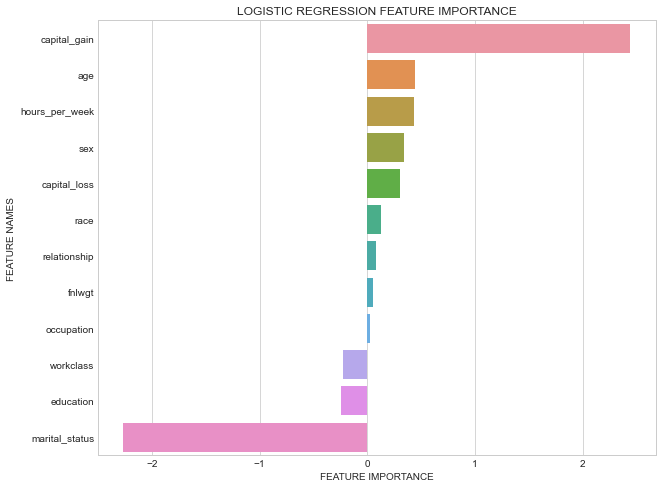

In [44]:
#logistic regression
if 'Logistic regression' not in models:
    models.append('Logistic regression')
lr_clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=300)
lr_clf.fit(X_train, y_train)
lr_predict = method_output(lr_clf)
plot_feature_importance(lr_clf.coef_[0], columns, 'Logistic regression')
predictions["lr"] = lr_predict

Test set confusion matrix:
 [[10661   689]
 [ 1405  2293]] 

Classification report:
                0      1
precision  0.884  0.769
recall     0.939  0.620
f1-score   0.911  0.687 

Test set accurancy score:
 0.861 

Train set accurancy score:
 0.906 



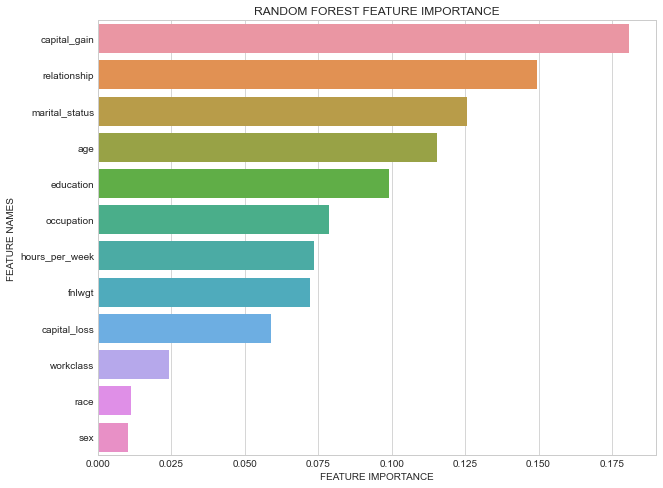

In [45]:
#random forest
if 'Random forest' not in models: 
    models.append('Random forest')
rf_clf = RandomForestClassifier(n_estimators=60, criterion='gini', random_state=4, max_depth=15)
rf_clf.fit(X_train, y_train)
rf_predict = method_output(rf_clf)
plot_feature_importance(rf_clf.feature_importances_, columns, 'Random forest')
predictions["rf"] = rf_predict

Test set confusion matrix:
 [[10639   711]
 [ 1292  2406]] 

Classification report:
                0      1
precision  0.892  0.772
recall     0.937  0.651
f1-score   0.914  0.706 

Test set accurancy score:
 0.867 

Train set accurancy score:
 0.892 



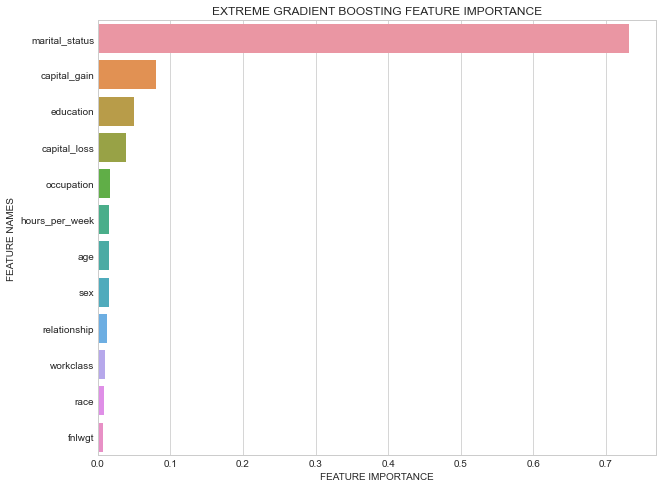

In [46]:
#Extreme Gradient Boosting
if 'Extreme Gradient Boosting' not in models: 
    models.append('Extreme Gradient Boosting')
xgb_clf = XGBClassifier(use_label_encoder=False, learning_rate=0.1, random_state=0, max_depth=8)
xgb_clf.fit(X_train, y_train, eval_metric='rmse')
xgb_predict = method_output(xgb_clf)
plot_feature_importance(xgb_clf.feature_importances_, columns, 'Extreme gradient boosting')
predictions["xgb"] = xgb_predict

In [47]:
#Histogram-based Gradient Boosting
if 'Histogram-based Gradient Boosting' not in models:
    models.append('Histogram-based Gradient Boosting')
hb_clf = HistGradientBoostingClassifier(learning_rate=0.05)
hb_clf.fit(X_train, y_train)
hb_predict = method_output(hb_clf)
predictions["hb"] = hb_predict

Test set confusion matrix:
 [[10667   683]
 [ 1306  2392]] 

Classification report:
                0      1
precision  0.891  0.778
recall     0.940  0.647
f1-score   0.915  0.706 

Test set accurancy score:
 0.868 

Train set accurancy score:
 0.874 



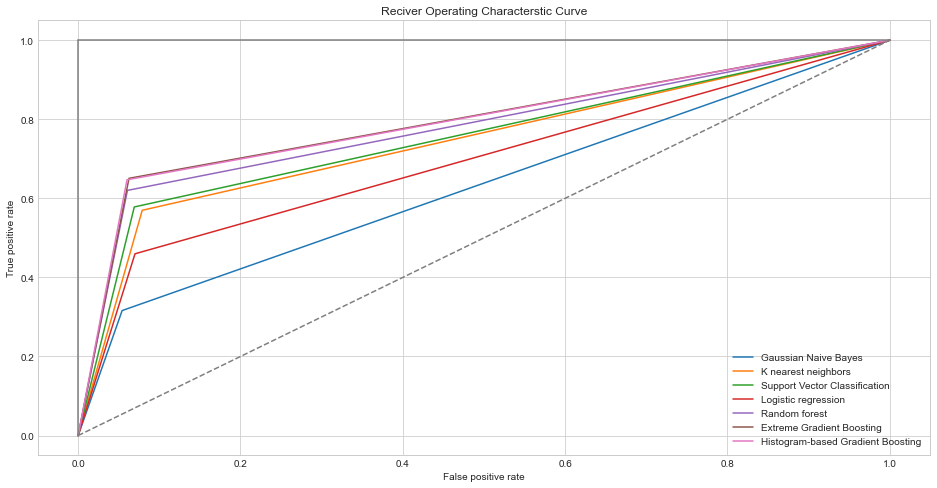

In [48]:
roc_curve_plot(predictions, models)

In [49]:
scores(predictions)

hb    xgb     rf    svc    knn     lr    gnb
precision        0.868  0.867  0.861  0.844  0.835  0.814  0.791
accurancy_score  0.778  0.772  0.769  0.731  0.702  0.681  0.655
auc_score        0.793  0.794  0.780  0.754  0.745  0.695  0.631